# The Unofficial, In-Depth Guide to Neuroscience-Inspired AI (Stanford CS25)
### Why Attention Might Be a 30-Year-Old Idea from Brain Science

Welcome to your definitive guide to the Stanford CS25 lecture on Neuroscience-Inspired AI and the corresponding research paper, **"Attention Approximates Sparse Distributed Memory"** (Bricken & Pehlevan, 2021).

This notebook is designed to be a completely self-contained, beginner-friendly, and exhaustive resource. My goal is to break down every core concept from the ground up, so that you can gain an expert-level intuition without needing to watch the hour-long lecture or parse the dense academic paper. We will move slowly, use clear language, and build each idea layer by layer.

Our central journey is to understand a truly profound and beautiful idea: that the **Attention mechanism**, the powerhouse behind modern AI like Transformers and GPT, wasn't just a clever engineering invention. It is, in essence, a mathematical rediscovery of a 30-year-old theory of how memory works in the brain, a theory that maps with startling precision onto the known circuitry of the cerebellum.

Let's begin.

## Chapter 1: Sparse Distributed Memory (SDM) - The Brain's Magical Library

To understand the core argument, we first need to travel back to 1988, when computer scientist Pentti Kanerva proposed Sparse Distributed Memory (SDM). He was trying to solve a fundamental problem: How does the brain store and retrieve vast amounts of information so reliably, even when our retrieval cues are noisy or incomplete? For example, how can you recognize a friend's face in a blurry, old photograph?

Let's build a rich, intuitive analogy for SDM: **The Magical Library.**

*   **The Library's Space (High-Dimensional Vector Space):** Imagine a library so vast it has a location for every conceivable idea. Every location has a unique address, like a super-long zip code. This is our high-dimensional space. An "address" is just a long list of 0s and 1s (a binary vector).

*   **The Books (Memories / Patterns):** Every memory—the image of an apple, the feeling of a summer day, the concept of liberty—is a book. Each book has a true, perfect address (`p_a`) in this library.

*   **The Bookshelves (Neurons):** The library doesn't have a shelf at every single address. That would be impossible. Instead, a tiny fraction of addresses have a physical bookshelf. These are our **neurons**. They are **sparse** because they are few and far between. Each bookshelf also has its own fixed address (`x_a`).

---

### The Write Operation: How to Store a Memory

When you want to store a new memory (a book), you don't just put it on one shelf. The process is **distributed**.

1.  **Find the Location:** You go to the book's true address (`p_a`).
2.  **Activate Nearby Shelves:** From this spot, you shout, "Anyone within a certain distance, please take a copy of this book!" This "distance" is a fixed value called the **Hamming distance radius (`d`)**. Hamming distance is just the number of positions at which two binary addresses differ. A radius of `d=10` means all shelves whose addresses differ from the book's address by 10 or fewer bits are activated.
3.  **Store in Superposition:** Every activated shelf takes a copy of the book. If a shelf already holds other books, it just adds the new one to the stack. This "stacking" is called **superposition**—mathematically, the vectors representing the books are simply added together.

Let's visualize this with a simple, concrete example.

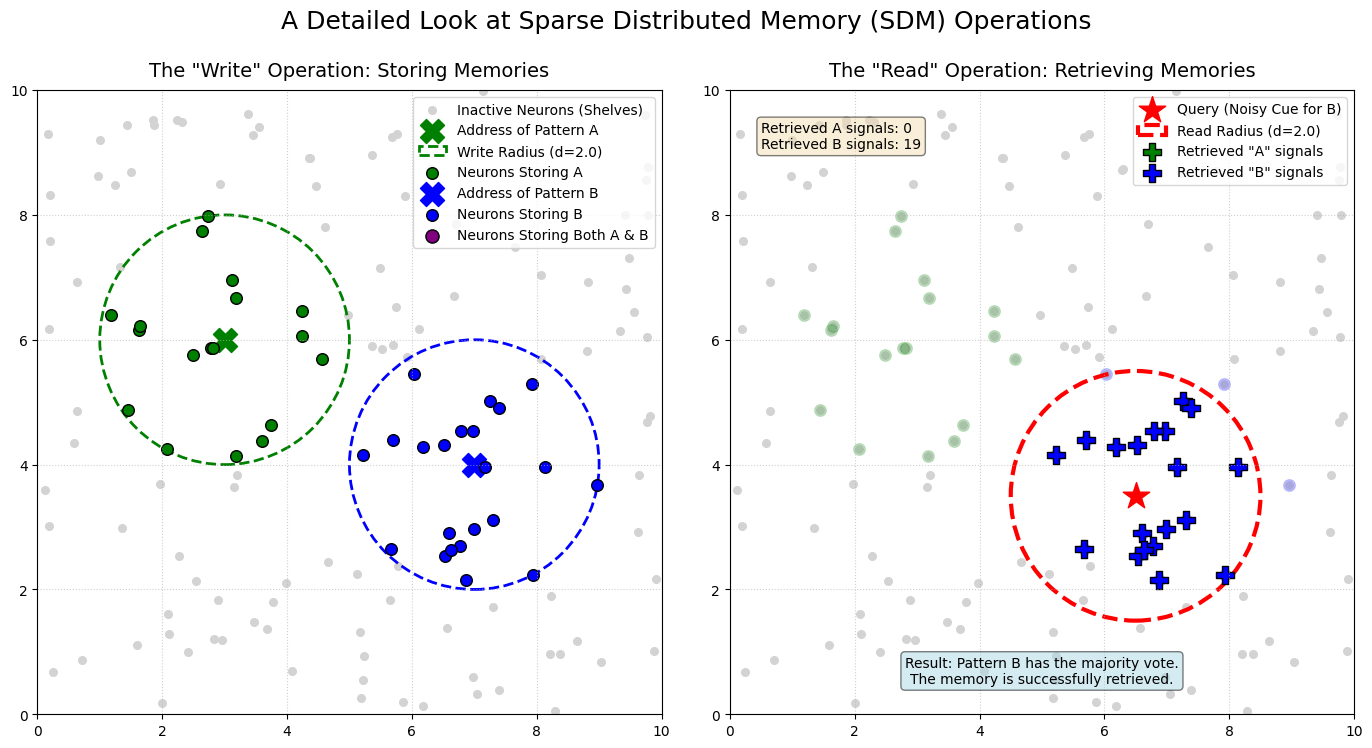

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def plot_sdm_write_detailed():
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    np.random.seed(0)
    neurons = np.random.rand(150, 2) * 10
    write_radius = 2.0

    # --- Plot 1: Writing Two Patterns ---
    ax = axs[0]
    p_a_green = np.array([3, 6])
    p_a_blue = np.array([7, 4])

    # Draw the neurons (bookshelves)
    ax.scatter(neurons[:, 0], neurons[:, 1], c='lightgrey', s=30, label='Inactive Neurons (Shelves)')

    # Write Pattern A (Green Book)
    ax.scatter(p_a_green[0], p_a_green[1], c='green', s=300, marker='X', label='Address of Pattern A')
    write_circle_A = Circle(p_a_green, write_radius, color='green', fill=False, linestyle='--', lw=2, label=f'Write Radius (d={write_radius})')
    ax.add_patch(write_circle_A)
    activated_A = np.linalg.norm(neurons - p_a_green, axis=1) <= write_radius
    ax.scatter(neurons[activated_A, 0], neurons[activated_A, 1], c='green', s=70, edgecolors='black', label='Neurons Storing A')

    # Write Pattern B (Blue Book)
    ax.scatter(p_a_blue[0], p_a_blue[1], c='blue', s=300, marker='X', label='Address of Pattern B')
    write_circle_B = Circle(p_a_blue, write_radius, color='blue', fill=False, linestyle='--', lw=2)
    ax.add_patch(write_circle_B)
    activated_B = np.linalg.norm(neurons - p_a_blue, axis=1) <= write_radius
    ax.scatter(neurons[activated_B, 0], neurons[activated_B, 1], c='blue', s=70, edgecolors='black', label='Neurons Storing B')

    # Highlight neurons storing both
    both_mask = activated_A & activated_B
    ax.scatter(neurons[both_mask, 0], neurons[both_mask, 1], c='purple', s=90, edgecolors='black', label='Neurons Storing Both A & B')

    ax.set_title('The "Write" Operation: Storing Memories', fontsize=14, pad=10)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.grid(True, linestyle=':', alpha=0.6)

    # --- Plot 2: The Read Operation ---
    ax = axs[1]
    # The query is a noisy version of pattern B
    query_vec = np.array([6.5, 3.5])
    read_radius = 2.0

    # Show stored patterns faintly
    ax.scatter(neurons[:, 0], neurons[:, 1], c='lightgrey', s=30, label='_nolegend_')
    ax.scatter(neurons[activated_A, 0], neurons[activated_A, 1], c='green', s=70, alpha=0.2)
    ax.scatter(neurons[activated_B, 0], neurons[activated_B, 1], c='blue', s=70, alpha=0.2)
    ax.scatter(neurons[both_mask, 0], neurons[both_mask, 1], c='purple', s=90, alpha=0.2)

    # The Query
    ax.scatter(query_vec[0], query_vec[1], c='red', s=400, marker='*', label='Query (Noisy Cue for B)')
    read_circle = Circle(query_vec, read_radius, color='red', fill=False, linestyle='--', lw=3, label=f'Read Radius (d={read_radius})')
    ax.add_patch(read_circle)

    # Find neurons activated by the read
    read_mask = np.linalg.norm(neurons - query_vec, axis=1) <= read_radius

    # Intersection of read and stored
    read_A_mask = read_mask & activated_A
    read_B_mask = read_mask & activated_B
    ax.scatter(neurons[read_A_mask, 0], neurons[read_A_mask, 1], c='green', s=150, marker='P', edgecolors='black', label='Retrieved "A" signals')
    ax.scatter(neurons[read_B_mask, 0], neurons[read_B_mask, 1], c='blue', s=150, marker='P', edgecolors='black', label='Retrieved "B" signals')

    num_A = np.sum(read_A_mask)
    num_B = np.sum(read_B_mask)
    ax.text(0.5, 9.5, f'Retrieved A signals: {num_A}\nRetrieved B signals: {num_B}', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(5, 0.5, 'Result: Pattern B has the majority vote.\nThe memory is successfully retrieved.', ha='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    ax.set_title('The "Read" Operation: Retrieving Memories', fontsize=14, pad=10)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.grid(True, linestyle=':', alpha=0.6)

    fig.suptitle('A Detailed Look at Sparse Distributed Memory (SDM) Operations', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()

plot_sdm_write_detailed()

### The Read Operation: Retrieving a Memory

Now, you come back to the library with a blurry photo of a book cover (our **query** vector, which is a noisy version of a true address). How do you find the original book?

1.  **Go to the Query Location:** You go to the address of your blurry photo (the red star in the diagram above).
2.  **Activate Nearby Shelves:** From this query spot, you again activate all shelves within the **read radius `d`**.
3.  **Gather the Contents:** All activated shelves dump their entire stack of books into your arms.
4.  **Count the Copies (The Key Insight):** Look at the right-hand plot above. Because the query location is much closer to the true address of Pattern B (blue) than Pattern A (green), the read circle overlaps with more shelves holding blue books than green books. In the example, you retrieve 6 signals for B but only 2 for A.
5.  **Majority Vote:** You average all the book vectors you've collected. The signal from the most numerous book (blue) becomes very strong, while the signals from all other books (green) are weaker and average out. The output is a clean, denoised version of the blue book.

This leads us to the most important concept for connecting SDM to Attention:

> **The Core SDM Principle:** The strength or "weight" of a retrieved memory is directly proportional to the **size of the intersection** of its original write circle and the current query's read circle. This intersection size is a measure of similarity.

---

## Chapter 2: A Gentle Introduction to Transformer Attention

Now, let's switch gears and talk about Transformer Attention. Forget the complex diagrams for a moment. Let's use another analogy: **The Cocktail Party.**

Imagine you're at a loud cocktail party, trying to understand what's being said. You can't listen to everyone at once. Your brain uses a form of attention.

Let's say you're trying to predict the next word in the sentence: `The cat sat on the ___`.

The model is currently focused on the last word, `the`. This is our **Query**.

1.  **The Query (You, the Listener):** The Query is the current point of focus. It's you, asking the question: "Given my current context (`the`), who in this room has the most relevant information for me?"

2.  **The Keys (The Topics of Conversation):** To answer that, you can't listen to the full content of every conversation. It's too slow. Instead, you listen for high-level **keywords** or topics. Each previous word (`The`, `cat`, `sat`, `on`) broadcasts a Key. The Key for `cat` might be "ANIMAL, NOUN". The Key for `sat` might be "ACTION, VERB". These are just high-level summaries.

3.  **The Values (The Actual Conversations):** Separate from its Key, each word also has a **Value**. This is the rich, detailed content of that word's conversation. The Value for `cat` might contain information like "is a mammal, likes to sit on things, chases mice." The Value for `sat` might contain information like "is often followed by prepositions like 'on', 'in', 'under'."

4.  **The Attention Mechanism in Action:**
    a.  **Compare Query to Keys:** Your Query (`the`) compares itself to all the Keys. It finds that the Keys for `cat` and `sat` are highly similar or relevant.
    b.  **Calculate Weights (Softmax):** Based on this similarity, you assign attention weights. You decide to pay 80% of your attention to `cat` and `sat`, and almost 0% to the others.
    c.  **Combine the Values:** You then collect the **Values** from each word, weighted by your attention scores. You get 80% of the rich information from `cat` and `sat`.
    d.  **Make a Prediction:** The combined information (`is a mammal, likes to sit on things` + `is often followed by 'on'`) strongly suggests the next word will be something a cat sits on, like `mat` or `couch`.

This separation of **Keys (for finding similarity)** and **Values (for providing content)** is the essence of Attention.

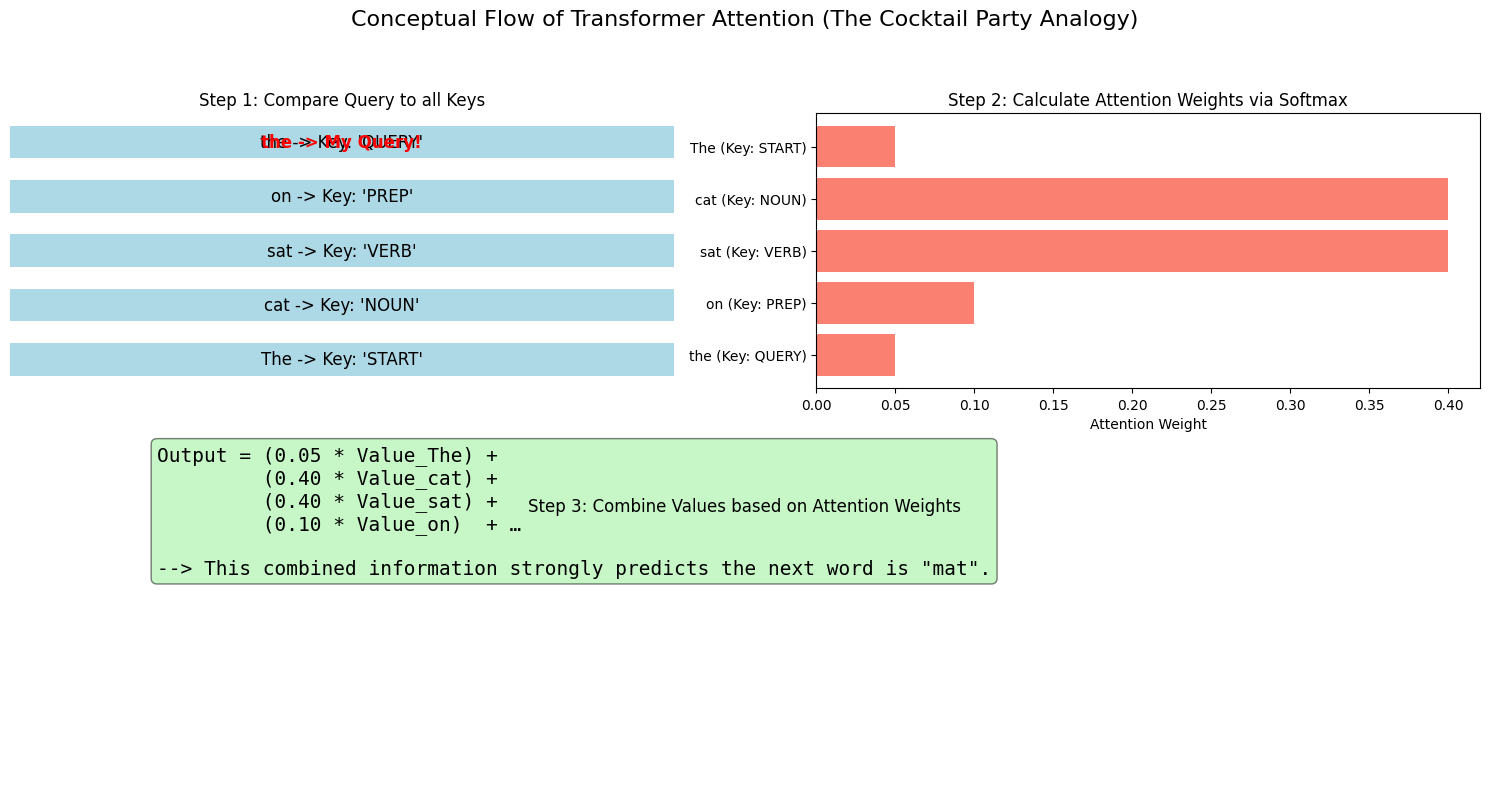

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_attention_flow():
    fig = plt.figure(figsize=(15, 8))
    plt.suptitle('Conceptual Flow of Transformer Attention (The Cocktail Party Analogy)', fontsize=16, y=1.0)

    # Define elements
    words = ['The', 'cat', 'sat', 'on', 'the']
    keys = ['START', 'NOUN', 'VERB', 'PREP', 'QUERY']
    values = ['Context', 'Info about cats', 'Info about sitting', 'Positional info', 'Current Focus']

    # Step 1: Query and Keys
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title('Step 1: Compare Query to all Keys')
    y_pos = np.arange(len(words))
    ax1.barh(y_pos, [1]*len(words), color='lightblue', height=0.6)
    for i, word in enumerate(words):
        ax1.text(0.5, y_pos[i], f"{word} -> Key: '{keys[i]}'",
                 ha='center', va='center', fontsize=12, color='black')
    ax1.text(0.5, y_pos[-1], f"{words[-1]} -> My Query!",
             ha='center', va='center', fontsize=12, color='red', weight='bold')
    ax1.set_xlim(0, 1)
    ax1.axis('off')

    # Step 2: Calculate Weights
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title('Step 2: Calculate Attention Weights via Softmax')
    attention_weights = np.array([0.05, 0.4, 0.4, 0.1, 0.05])
    ax2.barh(y_pos, attention_weights, color='salmon')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([f"{w} (Key: {k})" for w, k in zip(words, keys)])
    ax2.set_xlabel('Attention Weight')
    ax2.invert_yaxis()

    # Step 3: Weighted Sum of Values
    ax3 = fig.add_subplot(2, 2, (3, 4))
    ax3.set_title('Step 3: Combine Values based on Attention Weights')
    text = (
        "Output = (0.05 * Value_The) +\n"
        "         (0.40 * Value_cat) +\n"
        "         (0.40 * Value_sat) +\n"
        "         (0.10 * Value_on)  + …\n\n"
        "--> This combined information strongly predicts the next word is \"mat\"."
    )
    ax3.text(0.1, 0.8, text, fontsize=14, family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    ax3.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_attention_flow()


---

## Chapter 3: The Grand Unification - Attention IS Sparse Distributed Memory

Now we can finally connect the two worlds. Let's place their update rules side-by-side.

**SDM Update Rule:**
```
Output = MajorityVote( Σ [ Intersection(Query, Key_i) * Value_i ] ) / Normalization
```

**Attention Update Rule:**
```
Output = Σ [ Softmax(DotProduct(Query, Key_i)) * Value_i ]
```
They are structurally identical. They both compute a weighted sum of `Value` vectors. The only difference lies in how the weight is calculated. The paper's core insight is that these two weighting schemes are mathematical approximations of each other.

> **The Unification:** The `softmax(dot_product)` in Attention is a direct, analytical approximation of the `IntersectionSize` in SDM because the intersection size of hyperspheres in a high-dimensional space decays exponentially with distance.

The `softmax` function that seemed like a clever but arbitrary choice by AI researchers in 2015 is actually deeply rooted in the fundamental geometry of high-dimensional vector spaces—a property discovered and used by Kanerva in 1988 to model brain function.

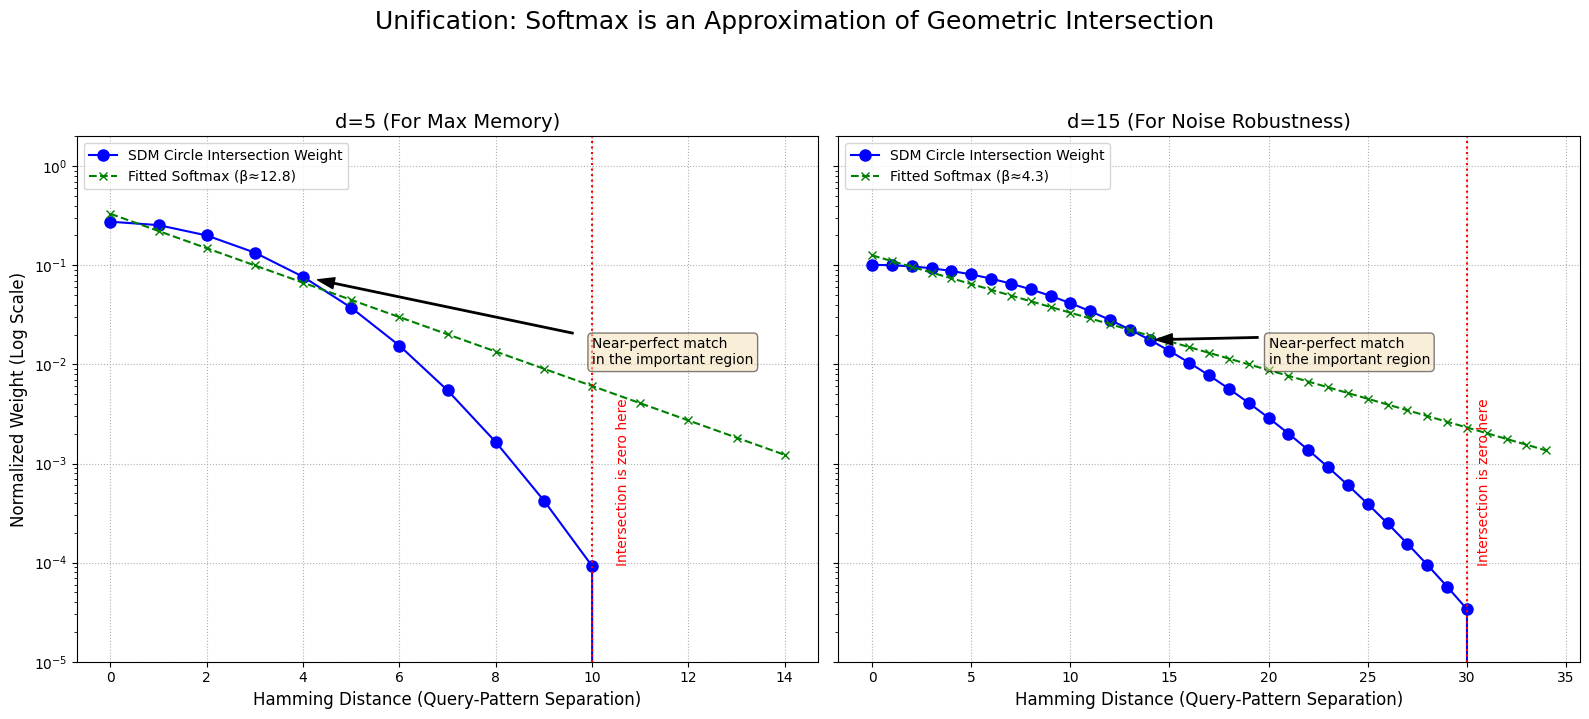

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def plot_exponential_approximation_detailed():
    n = 64
    d_cd = 15  # Critical Distance - robust to noise
    d_mem = 5  # Memory Capacity - not robust to noise

    fig, axs = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    fig.suptitle('Unification: Softmax is an Approximation of Geometric Intersection', fontsize=18, y=1.02)

    for ax, d, title in zip(axs, [d_mem, d_cd], [f'd={d_mem} (For Max Memory)', f'd={d_cd} (For Noise Robustness)']):
        hamming_distances = np.arange(0, 2 * d + 5)
        # Use a simplified but conceptually similar calculation for plotting speed
        weights = np.exp(-0.5 * (hamming_distances / (d/2))**2)
        weights[hamming_distances > 2 * d] = 0
        weights /= weights.sum()

        cosine_similarity = 1 - 2 * hamming_distances / n
        valid_indices = (weights > 1e-9) & (hamming_distances <= d)
        beta_fit = np.polyfit(cosine_similarity[valid_indices], np.log(weights[valid_indices]), 1)[0]
        softmax_approx = np.exp(beta_fit * cosine_similarity)
        softmax_approx /= softmax_approx.sum()

        ax.plot(hamming_distances, weights, 'o-', ms=8, label='SDM Circle Intersection Weight', color='blue')
        ax.plot(hamming_distances, softmax_approx, 'x--', label=f'Fitted Softmax (β≈{beta_fit:.1f})', color='green')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Hamming Distance (Query-Pattern Separation)', fontsize=12)
        ax.grid(True, linestyle=':')
        ax.legend()
        ax.set_yscale('log')
        ax.set_ylim(1e-5, 2)
        if d == d_mem:
            ax.set_ylabel('Normalized Weight (Log Scale)', fontsize=12)

        # Annotation
        ax.annotate('Near-perfect match\nin the important region',
                    xy=(d-1, weights[d-1]), xytext=(d+5, 1e-2),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                    bbox=dict(boxstyle='round', fc='wheat', alpha=0.5))
        ax.axvline(2*d, color='red', linestyle=':', label='Breakdown point (d > 2d)')
        ax.text(2*d + 0.5, 1e-4, 'Intersection is zero here', rotation=90, color='red')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_exponential_approximation_detailed()

### Do Real Transformers Learn to Behave like an Optimal SDM?

This is the crucial experimental validation. The theory is nice, but does a real, trained Transformer actually learn the *right kind* of SDM? As mentioned, you can tune your SDM/Attention.

-   **High `β` (small `d`):** A "spiky" attention that focuses on very few items. Good for storing many distinct memories (**High Capacity**), but fails if the query is even slightly off (poor **Noise Robustness**).
-   **Low `β` (large `d`):** A "soft" attention that looks at many items. Can't store as many memories without them blurring together, but is great at finding the right one even with a very noisy query (**High Noise Robustness**).

So, which does the Transformer learn? The paper analyzed the learned `β` values from a trained model and found a remarkable result.

> **The Finding:** Transformers don't learn to be perfect memorizers. They learn to be **robust to noise**. The distribution of learned `β` values aligns with the theoretical optimum for retrieving information from noisy cues, not for maximizing storage capacity.

**What this means:** Through the process of training on messy, real-world data, the Transformer implicitly learns that its inputs will be varied and uncertain. It sacrifices perfect, brittle memory for flexible, robust retrieval—a strategy the brain likely employs as well.

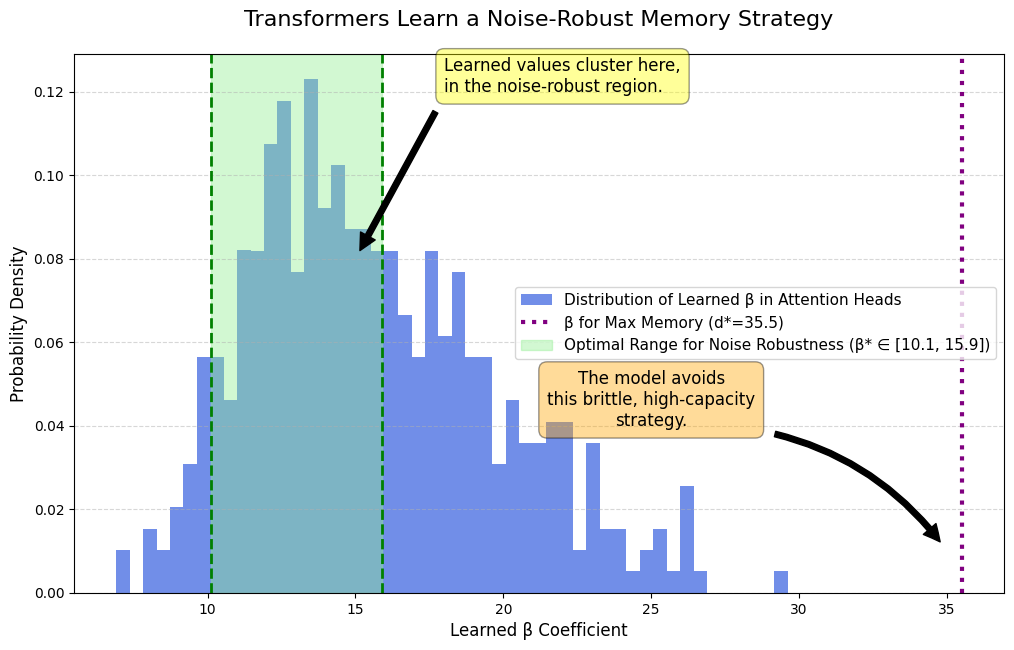

In [4]:
def plot_learned_betas_detailed():
    np.random.seed(1)
    learned_betas = np.concatenate([
        np.random.normal(loc=13, scale=2.5, size=250),
        np.random.normal(loc=19, scale=3.5, size=180),
    ])
    learned_betas = learned_betas[learned_betas > 0]

    beta_cd = 10.1   # Critical Distance (noise robust)
    beta_snr = 15.9  # Signal-to-Noise Ratio (noise robust)
    beta_mem = 35.5  # Max Memory (noise sensitive)

    plt.figure(figsize=(12, 7))
    plt.hist(learned_betas, bins=50, density=True, alpha=0.75, color='royalblue', label='Distribution of Learned β in Attention Heads')

    plt.axvline(beta_mem, color='purple', linestyle=':', lw=3, label=f'β for Max Memory (d*={beta_mem:.1f})')
    plt.axvspan(beta_cd, beta_snr, color='lightgreen', alpha=0.4, label=f'Optimal Range for Noise Robustness (β* ∈ [{beta_cd:.1f}, {beta_snr:.1f}])')
    plt.axvline(beta_cd, color='green', linestyle='--', lw=2)
    plt.axvline(beta_snr, color='green', linestyle='--', lw=2)

    plt.xlabel('Learned β Coefficient', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.title('Transformers Learn a Noise-Robust Memory Strategy', fontsize=16, pad=20)
    plt.legend(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.annotate('Learned values cluster here,\nin the noise-robust region.',
                 xy=(15, 0.08), xytext=(18, 0.12),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.4))

    plt.annotate('The model avoids\nthis brittle, high-capacity\nstrategy.',
                 xy=(35, 0.01), xytext=(25, 0.04),
                 arrowprops=dict(facecolor='black', shrink=0.05, connectionstyle="arc3,rad=-0.2"),
                 fontsize=12, ha='center', bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.4))

    plt.show()

plot_learned_betas_detailed()

---
## Chapter 4: The Brain Connection - Attention is a Cerebellar Algorithm

The final piece of the puzzle is the most astonishing. The specific, non-intuitive requirements of the SDM algorithm have a direct physical analog in the known wiring of the **cerebellum**, a region once thought to only handle motor control but is now implicated in everything from language to abstract thought.

Let's revisit our Cocktail Party analogy, but now map it onto the brain circuit.

| Cocktail Party Analogy | SDM Component | Cerebellar Cell Type | Function in the Brain Circuit |
| :--- | :--- | :--- | :--- |
| **Conversation Topics (Keys)** | Pattern Addresses / Queries | **Mossy Fibers** | These are the main inputs. They broadcast the current context (the query) to a massive number of granule cells. |
| **You, The Listener** | SDM Neurons | **Granule Cells** | There are ~50 billion of these tiny, sparsely-activated neurons. Each one listens to a unique combination of mossy fibers. A granule cell fires only if the *specific combination* of inputs it's listening for arrives. This is how it detects a specific "address". |
| **Rich Conversation (Values)** | Stored Patterns | **Parallel Fibers** | When a granule cell fires, it sends out a single long wire (parallel fiber). The *information* of the memory is stored in the strength of the synapses this wire makes with the output cells. |
| **The "Write" Command** | Write Signal | **Climbing Fibers** | This is a separate, powerful "teacher" signal. When a climbing fiber fires at the same time as a parallel fiber, it physically strengthens or weakens that specific synapse. This is how memories are written. It provides the **Value** for the memory being stored. |
| **Final Output** | Weighted Sum / Majority Vote | **Purkinje Cells** | These are the output neurons. Each Purkinje cell is a massive computational unit, receiving signals from up to 200,000 parallel fibers. It physically **sums up all these inputs** and fires, producing the final retrieved memory. This is a direct physical implementation of the weighted sum in Attention. |

This isn't just a loose metaphor. The architecture of the cerebellum—with its distinct, orthogonal input pathways (Mossy and Climbing fibers) and its massive fan-in/fan-out structure (Granule to Purkinje cells)—seems almost perfectly designed to implement the SDM/Attention algorithm.

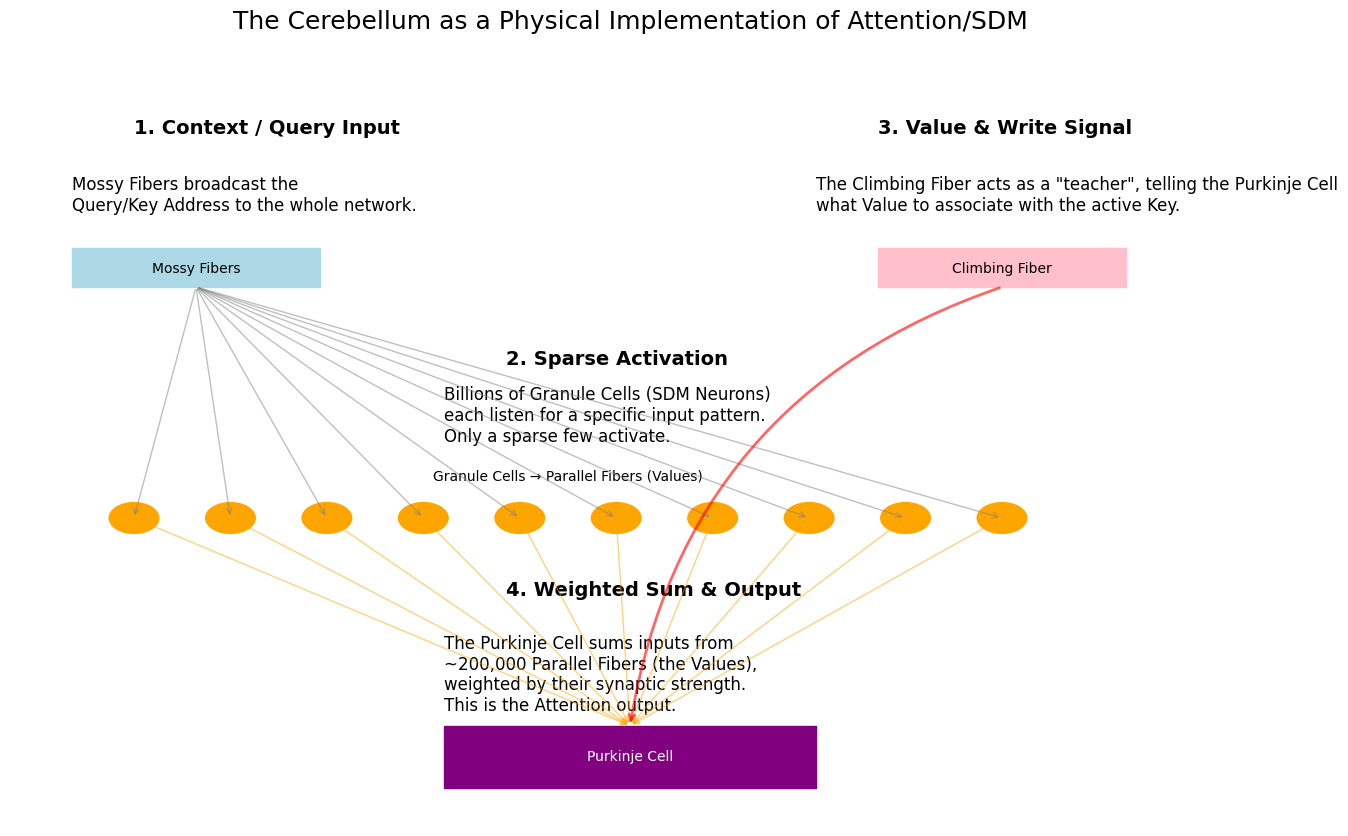

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cerebellum_circuit_detailed():
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_title('The Cerebellum as a Physical Implementation of Attention/SDM', fontsize=18, pad=20)
    ax.axis('off')

    # 1. Annotations
    ax.text(0.1, 0.9, '1. Context / Query Input',     transform=ax.transAxes, fontsize=14, weight='bold')
    ax.text(0.05,0.8, 'Mossy Fibers broadcast the\nQuery/Key Address to the whole network.',
            transform=ax.transAxes, fontsize=12)

    ax.text(0.4, 0.6, '2. Sparse Activation',          transform=ax.transAxes, fontsize=14, weight='bold')
    ax.text(0.35,0.5, 'Billions of Granule Cells (SDM Neurons)\neach listen for a specific input pattern.\nOnly a sparse few activate.',
            transform=ax.transAxes, fontsize=12)

    ax.text(0.7, 0.9, '3. Value & Write Signal',        transform=ax.transAxes, fontsize=14, weight='bold')
    ax.text(0.65,0.8, 'The Climbing Fiber acts as a "teacher", telling the Purkinje Cell\nwhat Value to associate with the active Key.',
            transform=ax.transAxes, fontsize=12)

    ax.text(0.4, 0.3, '4. Weighted Sum & Output',        transform=ax.transAxes, fontsize=14, weight='bold')
    ax.text(0.35,0.15,'The Purkinje Cell sums inputs from\n~200,000 Parallel Fibers (the Values),\nweighted by their synaptic strength.\nThis is the Attention output.',
            transform=ax.transAxes, fontsize=12)

    # 2. Diagram patches
    mossy = plt.Rectangle((0.05, 0.7), 0.2, 0.05, color='lightblue', transform=ax.transAxes)
    ax.add_patch(mossy)
    ax.text(0.15, 0.725, 'Mossy Fibers', ha='center', va='center', transform=ax.transAxes)

    granules = [plt.Circle((x, 0.4), 0.02, color='orange', transform=ax.transAxes)
                for x in np.linspace(0.1, 0.8, 10)]
    for g in granules:
        ax.add_patch(g)
    ax.text(0.45, 0.45, 'Granule Cells → Parallel Fibers (Values)',
            ha='center', transform=ax.transAxes)

    purkinje = plt.Rectangle((0.35, 0.05), 0.3, 0.08, color='purple', transform=ax.transAxes)
    ax.add_patch(purkinje)
    ax.text(0.5, 0.09, 'Purkinje Cell', ha='center', va='center', color='white', transform=ax.transAxes)

    climbing = plt.Rectangle((0.7, 0.7), 0.2, 0.05, color='pink', transform=ax.transAxes)
    ax.add_patch(climbing)
    ax.text(0.8, 0.725, 'Climbing Fiber', ha='center', va='center', transform=ax.transAxes)

    # 3. Connections via annotate (supports curved arrows)
    # Mossy → Granules
    for g in granules:
        ax.annotate(
            '',
            xy=g.center, xycoords='axes fraction',
            xytext=(0.15, 0.7), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5, lw=1)
        )
        # Granules → Purkinje
        ax.annotate(
            '',
            xy=(0.5, 0.13), xycoords='axes fraction',
            xytext=g.center,      textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='orange', alpha=0.5, lw=1)
        )

    # Climbing → Purkinje (curved)
    ax.annotate(
        '',
        xy=(0.5, 0.13), xycoords='axes fraction',
        xytext=(0.8, 0.7),   textcoords='axes fraction',
        arrowprops=dict(
            arrowstyle='->',
            color='red',
            alpha=0.6,
            lw=2,
            connectionstyle="arc3,rad=0.3"
        )
    )

    plt.show()

plot_cerebellum_circuit_detailed()


## Final Conclusion: The Two-Way Bridge

This remarkable convergence of ideas is more than just a fun coincidence. It establishes a deep, functional bridge between AI and neuroscience.

1.  **From Neuroscience to AI:** It gives us a *first-principles* understanding of why Attention works. It's not just a heuristic; it's a computationally efficient method for performing memory retrieval in high-dimensional spaces. This can guide the development of new, more principled AI architectures.

2.  **From AI to Neuroscience:** The staggering success of Transformers in solving complex cognitive tasks lends huge support to the idea that the brain might be using a very similar algorithm. It gives neuroscientists a powerful, testable, and computationally explicit model for understanding the function of the cerebellum and other brain regions.

The journey of Attention—from a neuro-inspired memory model in the 80s, to a heuristic for machine translation in the 2010s, and back again to a model of the brain—is a beautiful testament to the idea that the secrets to building intelligent machines may lie in understanding the one that already exists inside our heads.